# **eZnalec - Price predicting & analytic model for apartments**

In [42]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.linear_model import ElasticNet, ElasticNetCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score
import json

# Data preparation (MICE)

Load the data

In [2]:
df = pd.read_csv('merged_apt_data.csv')
df.head()


,price,1+1,1+kk,2+1,2+kk,3+1,3+kk,4+1,4+kk,5+1,...,kindergarden,small_store,big_store,pub,restaurant,post_office,atm,nature_place,pharmacy,sports
0,6148000,0,0,0,1,0,0,0,0,0,...,577,319,966.0,1110,62,1003,693,2609.0,644,62
1,9490000,0,0,0,1,0,0,0,0,0,...,294,431,1809.0,301,197,364,523,NaN,609,387
2,19373005,0,0,0,0,0,1,0,0,0,...,319,707,707.0,1634,374,799,483,1883.0,776,676
3,7000000,0,0,0,1,0,0,0,0,0,...,196,76,1635.0,774,97,961,382,4511.0,542,81
4,26278859,0,0,0,0,0,1,0,0,0,...,468,732,1466.0,1017,619,1077,820,NaN,962,592


Inspect the missing data

In [3]:
missing_values = df.isnull().sum()
missing_values

#here we can see how many energy levels are missing in our dataset for example
missing_energy_level = df['energy_level'].isnull().sum()
missing_energy_level

np.int64(392)

Applying MICE

In [4]:
imputer = IterativeImputer()
df_imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
#we can see that the energy levels which are not .00 are now imputed
df_imputed['energy_level'].head(30)

0     7.000000
1     1.000000
2     2.000000
3     4.000000
4     2.000000
5     3.439727
6     2.000000
7     2.000000
8     3.000000
9     2.000000
10    2.000000
11    7.000000
12    3.568650
13    2.000000
14    2.000000
15    4.000000
16    3.543069
17    2.650231
18    2.962034
19    4.923415
20    2.000000
21    2.000000
22    3.000000
23    7.000000
24    3.000000
25    7.000000
26    3.000000
27    3.000000
28    1.000000
29    4.000000
Name: energy_level, dtype: float64

Evaluation of imputation

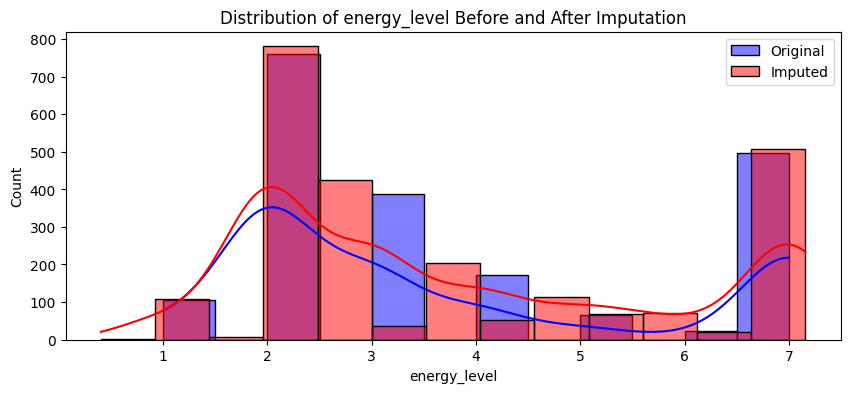

In [5]:
# Visualize the distribution of a few selected columns before and after imputation
import matplotlib.pyplot as plt
import seaborn as sns

# Select column to visualize
column = 'energy_level'  

plt.figure(figsize=(10, 4))

# Original data distribution
sns.histplot(df[column].dropna(), color='blue', label='Original', kde=True)

# Imputed data distribution
# This exapmle is for the energy level column, feel free to change the column name to visualize other columns
sns.histplot(df_imputed[column], color='red', label='Imputed', kde=True)

plt.title(f'Distribution of {column} Before and After Imputation')
plt.legend()



plt.show()

# Training the model

## Linear regression with elastic net regularization and cross-validation methodology for data

Data separation

In [6]:
y = df_imputed['price']
X = df_imputed.drop(columns=['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#first test on ols model, the most basic
ols = LinearRegression()
ols.fit(X_train, y_train)

print("r^2 on train data is {}".format(ols.score(X_train, y_train)))
print("r^2 on test data is {}".format(ols.score(X_test, y_test)))

r^2 on train data is 0.9384620901171774
r^2 on test data is 0.908093956107316


Now with elastic net model + we need to scale data for this 

In [ ]:
y = df_imputed['price']
X = df_imputed.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


elastic_net = ElasticNet(max_iter=10000)
parameters = {
    'alpha': np.linspace(0.01, 10.0, 20),
    'l1_ratio': np.linspace(0.01, 0.9, 20)
}

grid_search = GridSearchCV(estimator=elastic_net, param_grid=parameters, cv=10, scoring='r2')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 on test data: ", r2)

Best parameters found:  {'alpha': np.float64(0.01), 'l1_ratio': np.float64(0.8063157894736842)}
r2 on test data:  0.9106576067940632


The best **alpha (strength of the reqularization)** is **0.01** and **l1_ratio (lasso)** is **0.80**. Which means that we are using **80% Lasso** and **20% Ridge**. Plus we did **10 folds on cross validation** for the data and the accuracy is now **91%**.

# Analysis

## Feature importance

Text(0.5, 1.0, 'Top 20 Features in Elastic Net Model (olute value of coefficients)')

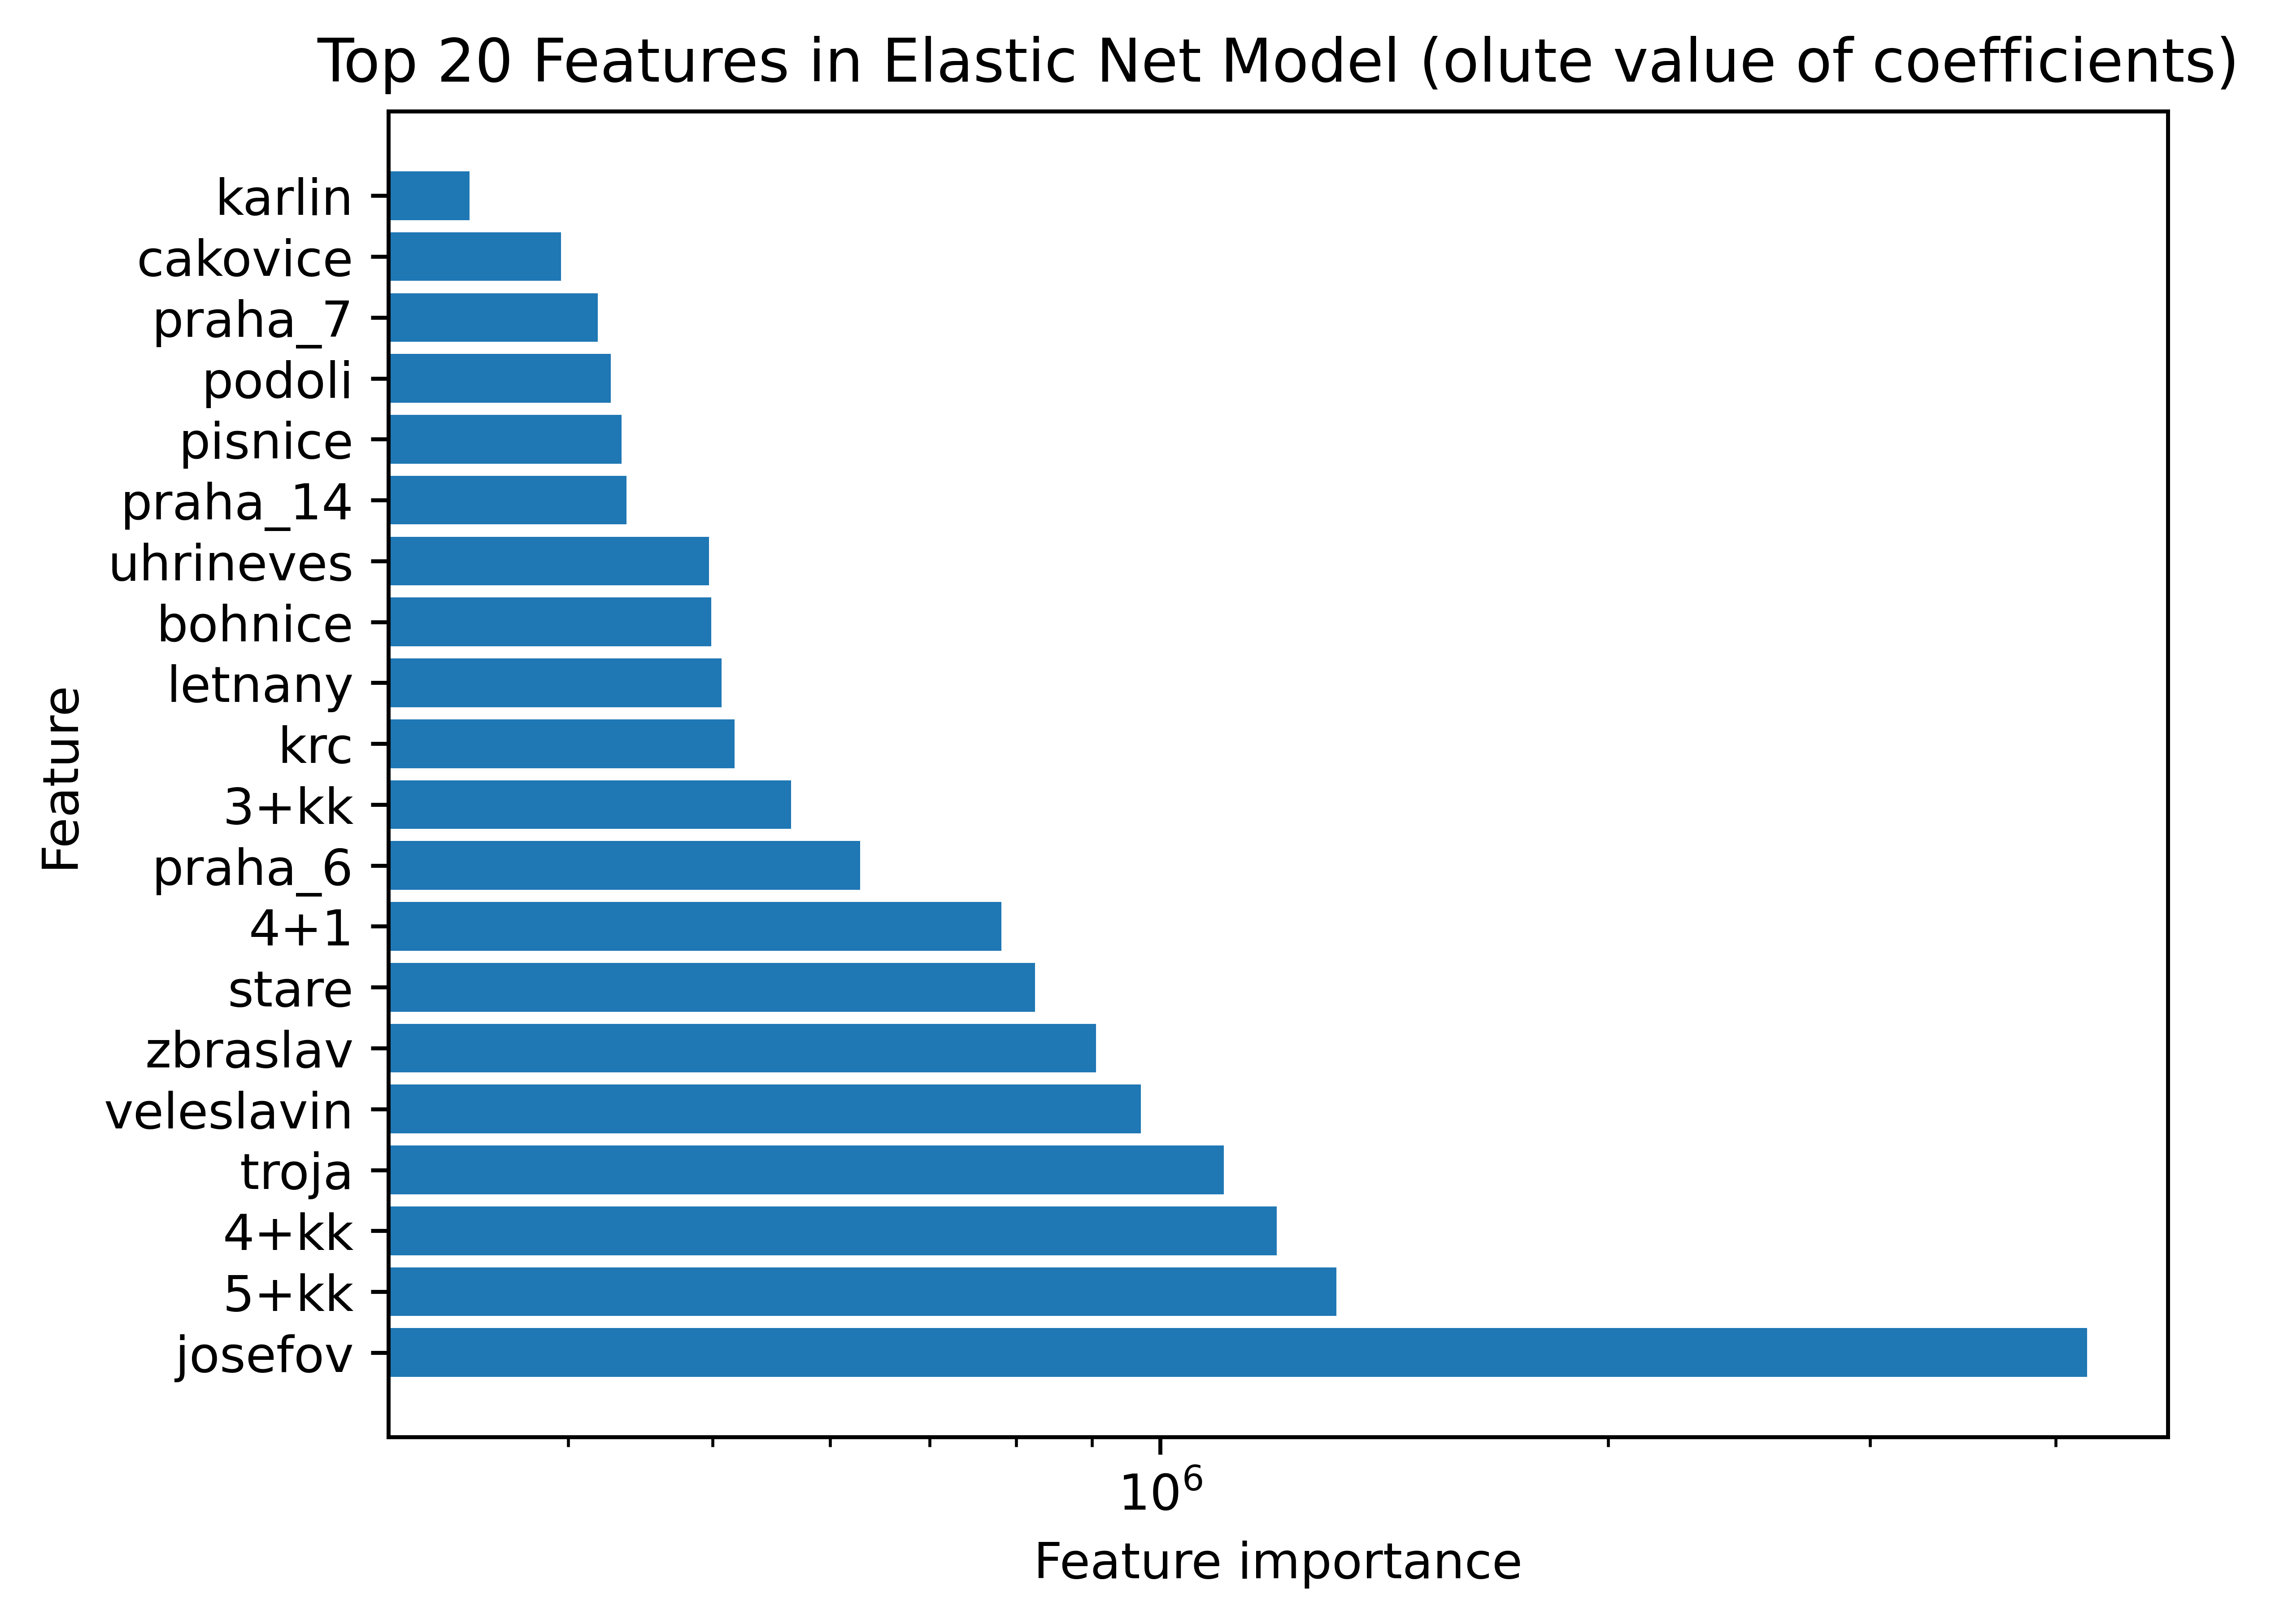

In [9]:
coef = (best_model.coef_)
top_20_feature = np.argsort(coef)[-20:][::-1]
plt.figure(dpi=800)
plt.barh(range(20), best_model.coef_[top_20_feature], align='center')
plt.yticks(range(20), X.columns[top_20_feature])
plt.xlabel("Feature importance")
plt.xscale('log')
plt.ylabel("Feature")
plt.title("Top 20 Features in Elastic Net Model (olute value of coefficients)")

- Here we can see that "thanks" for **one-hot-encoding** method for **locations** in prague, most of the top 20 features are the **specific location**.
- Our model evaluated that **Josefov (historical centre of Prague)** is very imporant in price prediciting.
- Otherwise, we can see that the apartment's **room layout** are also very important, however, just the **larger ones**.

Next, **locations** and **layouts** are going to **general features** not separate (one-hot-encoding style like now), so we can see **importance of other features** as well. 


In [10]:
#load the importance of the features into a dataframe
feature_importances = np.abs(best_model.coef_)

feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
})

locations = ['chodov',
                'hlubocepy',
                'smichov',
                'vysocany',
                'zizkov',
                'vinohrady',
                'modrany',
                'nove',
                'liben',
                'vrsovice',
                'cakovice',
                'krc',
                'nusle',
                'radlice',
                'satalice',
                'haje',
                'horni',
                'branik',
                'holesovice',
                'dolni',
                'stodulky',
                'mala',
                'praha_1',
                'kosire',
                'troja',
                'brevnov',
                'praha_8',
                'kyje',
                'vysehrad',
                'karlin',
                'kbely',
                'pitkovice',
                'sobin',
                'cerny',
                'treboradice',
                'cimice',
                'strizkov',
                'praha_9',
                'letnany',
                'kobylisy',
                'dejvice',
                'praha_14',
                'bubenec',
                'radotin',
                'ujezd',
                'suchdol',
                'hostavice',
                'praha_5',
                'podoli',
                'zlicin',
                'veleslavin',
                'michle',
                'hostivar',
                'strasnice',
                'petrovice',
                'praha_4',
                'zbraslav',
                'stare',
                'bohnice',
                'kolovraty',
                'kamyk',
                'trebonice',
                'zabehlice',
                'ruzyne',
                'jinonice',
                'malesice',
                'motol',
                'prosek',
                'vokovice',
                'repy',
                'hloubetin',
                'lochkov',
                'lipence',
                'liboc',
                'josefov',
                'hrdlorezy',
                'slivenec',
                'sterboholy',
                'praha_7',
                'hodkovicky',
                'cholupice',
                'miskovice',
                'uhrineves',
                'stresovice',
                'dubec',
                'lhotka',
                'velka',
                'pisnice',
                'klanovice',
                'dablice',
                'vinor',
                'holyne',
                'praha_10',
                'libus',
                'hajek',
                'praha_2',
                'reporyje',
                'seberov',
                'bechovice',
                'kolodeje',
                'hradcany',
                'praha_6',
                'tocna',
                'kralovice',
                'kunratice',
                'praha_11',
                'dolni_brezany',]

#identify the one-hot encoded locations
location_features = [col for col in X.columns if col in locations]

#sum the importances of the one-hot encoded location features
location_importance = feature_importances_df[feature_importances_df['feature'].isin(location_features)]['importance'].sum()

#exclude the one-hot encoded location features from the DataFrame
feature_importances_df = feature_importances_df[~feature_importances_df['feature'].isin(location_features)]

#create a new DataFrame for the new general location importance
location_importance_df = pd.DataFrame({'feature': ['location'], 'importance': [location_importance]})



#concatenate the new DataFrame with the original feature importances DataFrame
feature_importances_df = pd.concat([feature_importances_df, location_importance_df], ignore_index=True)

feature_importances_df

,feature,importance
0,1+1,8.219219e+05
1,1+kk,1.634944e+06
2,2+1,1.757982e+05
3,2+kk,2.574503e+05
4,3+1,3.292665e+05
...,...,...
56,atm,1.126466e+02
57,nature_place,1.936167e+02
58,pharmacy,1.727956e+02
59,sports,2.744099e+02


Now lets do the same for apartment's room layout

In [11]:
layouts = ['1+1',
                '1+kk',
                '2+1',
                '2+kk',
                '3+1',
                '3+kk',
                '4+1',
                '4+kk',
                '5+1',
                '5+kk',
                '6-a-vice',
                'atypicky',]

#identify the one-hot encoded layouts
layout_features = [col for col in X.columns if col in layouts]

#sum the importances of the one-hot encoded layout features
layout_importance = feature_importances_df[feature_importances_df['feature'].isin(layout_features)]['importance'].sum()

#exclude the one-hot encoded layout features from the DataFrame
feature_importances_df = feature_importances_df[~feature_importances_df['feature'].isin(layout_features)]

#create a new DataFrame for the new general layout importance
layout_importance_df = pd.DataFrame({'feature': ['layout'], 'importance': [layout_importance]})

#concatenate the new DataFrame with the original feature importances DataFrame
feature_importances_df = pd.concat([feature_importances_df, layout_importance_df], ignore_index=True)

feature_importances_df

,feature,importance
0,size,1.370564e+05
1,price_per_m2,7.579044e+01
2,energy_level,1.988587e+03
3,floor,2.372113e+03
4,Ve velmi dobrem stavu,1.895728e+05
5,V dobrem stavu,1.506729e+04
6,Ve spatnem stavu,0.000000e+00
7,Ve vystavbe,5.707008e+04
8,Projekt,2.198025e+05
9,Novostavba,2.350510e+04


- Now **layouts and locations** have their own general importance columns.
- Lets see the **feature importance** horizontal barchart again.

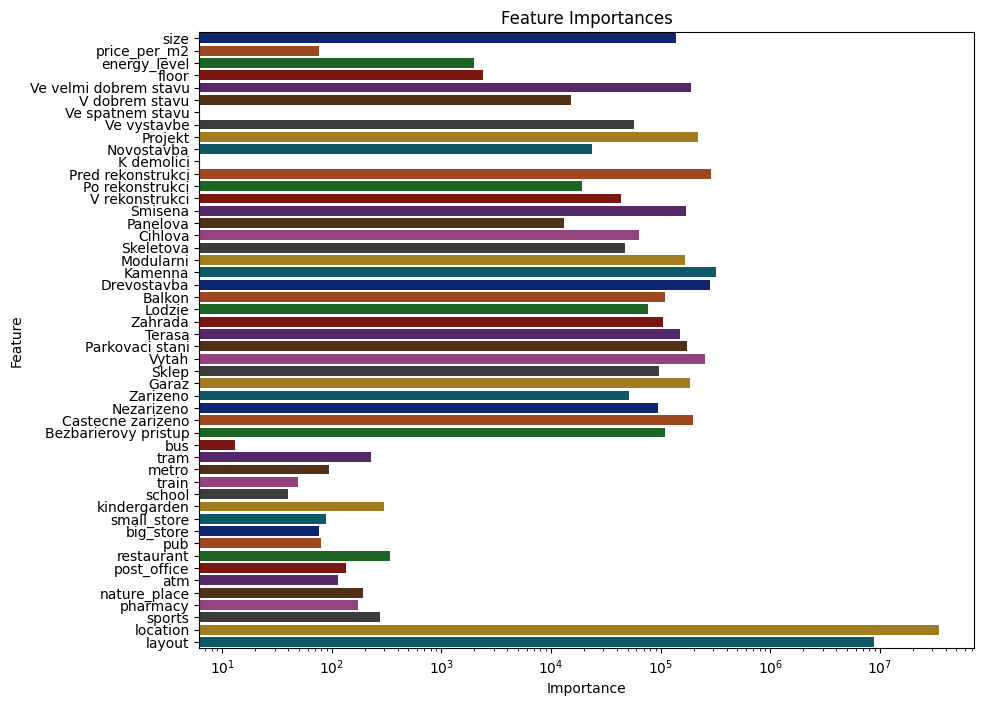

In [36]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', hue='feature', data=feature_importances_df, palette='dark', dodge=False, legend=False)

plt.xscale('log')

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

- Here we can see that **location is everything** in real-estate, following with the **layout**.
- Following with **stone built** (Kamenna).
- Interesting is that we can see that **'Before renovation'** (Pred rekonstrukci) is important, but most likely in **price going down** with this feature.
- **Energy level** and **floor** is not that important in price evaluation for this model, however it is still more important than the proximities to amenities which are the least important overall category.
- Interesting detail is, that people **might not care about bus stop** that much as for **tram**, which is propably **more valuable** than bus stop for **Prague residents**.

## Correlation matrix

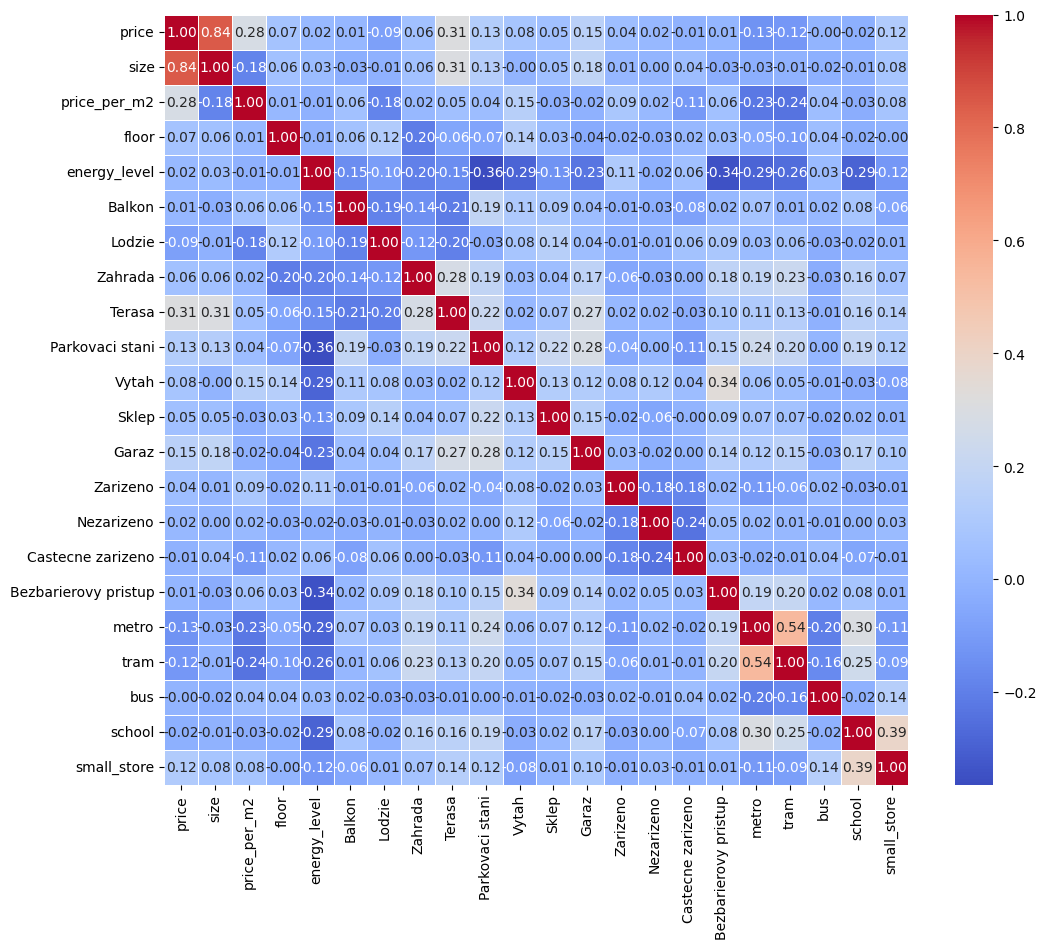

In [13]:
filtered_df = df_imputed[['price', 'size', 'price_per_m2', 'floor', 'energy_level', 'Balkon', 'Lodzie','Zahrada', 'Terasa', 'Parkovaci stani', 'Vytah', 'Sklep', 'Garaz', 'Zarizeno', 'Nezarizeno', 'Castecne zarizeno', 'Bezbarierovy pristup','metro', 'tram', 'bus','school', 'small_store']]
matrix = filtered_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

#display the plot
plt.show()

- Here we can see that size and terace has considerable correlation.
- More interesting considerable correlations: Garage and parking spot, garage and terace, accesiblity and elevator, tram and metro, school and small store, school and metro

# Test out the model with your apartment

- Here the code reads your input to **myApt.json** file, **read README.md** file for intructions how to fill out this file.
- When trying out this model just input your apt. to the .json file, save it, and **run all cells below starting at this one.**

In [57]:
#do not input here this is just default format, input your apartment to myApt.json file instead
locations = ['chodov',
                'hlubocepy',
                'smichov',
                'vysocany',
                'zizkov',
                'vinohrady',
                'modrany',
                'nove',
                'liben',
                'vrsovice',
                'cakovice',
                'krc',
                'nusle',
                'radlice',
                'satalice',
                'haje',
                'horni',
                'branik',
                'holesovice',
                'dolni',
                'stodulky',
                'mala',
                'praha_1',
                'kosire',
                'troja',
                'brevnov',
                'praha_8',
                'kyje',
                'vysehrad',
                'karlin',
                'kbely',
                'pitkovice',
                'sobin',
                'cerny',
                'treboradice',
                'cimice',
                'strizkov',
                'praha_9',
                'letnany',
                'kobylisy',
                'dejvice',
                'praha_14',
                'bubenec',
                'radotin',
                'ujezd',
                'suchdol',
                'hostavice',
                'praha_5',
                'podoli',
                'zlicin',
                'veleslavin',
                'michle',
                'hostivar',
                'strasnice',
                'petrovice',
                'praha_4',
                'zbraslav',
                'stare',
                'bohnice',
                'kolovraty',
                'kamyk',
                'trebonice',
                'zabehlice',
                'ruzyne',
                'jinonice',
                'malesice',
                'motol',
                'prosek',
                'vokovice',
                'repy',
                'hloubetin',
                'lochkov',
                'lipence',
                'liboc',
                'josefov',
                'hrdlorezy',
                'slivenec',
                'sterboholy',
                'praha_7',
                'hodkovicky',
                'cholupice',
                'miskovice',
                'uhrineves',
                'stresovice',
                'dubec',
                'lhotka',
                'velka',
                'pisnice',
                'klanovice',
                'dablice',
                'vinor',
                'holyne',
                'praha_10',
                'libus',
                'hajek',
                'praha_2',
                'reporyje',
                'seberov',
                'bechovice',
                'kolodeje',
                'hradcany',
                'praha_6',
                'tocna',
                'kralovice',
                'kunratice',
                'praha_11',
                'dolni_brezany']
conditions = ['Ve velmi dobrem stavu', 'V dobrem stavu', 'Ve spatnem stavu', 'Ve vystavbe', 'Projekt', 'Novostavba', 'K demolici', 'Pred rekonstrukci', 'Po rekonstrukci', 'V rekonstrukci']
my_apt_default = {
                '1+1': 0,
                '1+kk': 0,
                '2+1': 0,
                '2+kk': 0,
                '3+1': 0,
                '3+kk': 0,
                '4+1': 0,
                '4+kk': 0,
                '5+1': 0,
                '5+kk': 0,
                '6-a-vice': 0,
                'atypicky': 0,
                #-------------
                #put 1 to your location, use ctrl+f to find your location, use only one location from this list
                'chodov': 0,
                'hlubocepy': 0,
                'smichov': 0,
                'vysocany': 0,
                'zizkov': 0,
                'vinohrady': 0,
                'modrany': 0,
                'nove': 0,
                'liben': 0,
                'vrsovice': 0,
                'cakovice': 0,
                'krc': 0,
                'nusle': 0,
                'radlice': 0,
                'satalice': 0,
                'haje': 0,
                'horni': 0,
                'branik': 0,
                'holesovice': 0,
                'dolni': 0,
                'stodulky': 0,
                'mala': 0,
                'praha_1': 0,
                'kosire': 0,
                'troja': 0,
                'brevnov': 0,
                'praha_8': 0,
                'kyje': 0,
                'vysehrad': 0,
                'karlin': 0,
                'kbely': 0,
                'pitkovice': 0,
                'sobin': 0,
                'cerny': 0,
                'treboradice': 0,
                'cimice': 0,
                'strizkov': 0,
                'praha_9': 0,
                'letnany': 0,
                'kobylisy': 0,
                'dejvice': 0,
                'praha_14': 0,
                'bubenec': 0,
                'radotin': 0,
                'ujezd': 0,
                'suchdol': 0,
                'hostavice': 0,
                'praha_5': 0,
                'podoli': 0,
                'zlicin': 0,
                'veleslavin': 0,
                'michle': 0,
                'hostivar': 0,
                'strasnice': 0,
                'petrovice': 0,
                'praha_4': 0,
                'zbraslav': 0,
                'stare': 0,
                'bohnice': 0,
                'kolovraty': 0,
                'kamyk': 0,
                'trebonice': 0,
                'zabehlice': 0,
                'ruzyne': 0,
                'jinonice': 0,
                'malesice': 0,
                'motol': 0,
                'prosek': 0,
                'vokovice': 0,
                'repy': 0,
                'hloubetin': 0,
                'lochkov': 0,
                'lipence': 0,
                'liboc': 0,
                'josefov': 0,
                'hrdlorezy': 0,
                'slivenec': 0,
                'sterboholy': 0,
                'praha_7': 0,
                'hodkovicky': 0,
                'cholupice': 0,
                'miskovice': 0,
                'uhrineves': 0,
                'stresovice': 0,
                'dubec': 0,
                'lhotka': 0,
                'velka': 0,
                'pisnice': 0,
                'klanovice': 0,
                'dablice': 0,
                'vinor': 0,
                'holyne': 0,
                'praha_10': 0,
                'libus': 0,
                'hajek': 0,
                'praha_2': 0,
                'reporyje': 0,
                'seberov': 0,
                'bechovice': 0,
                'kolodeje': 0,
                'hradcany': 0,
                'praha_6': 0,
                'tocna': 0,
                'kralovice': 0,
                'kunratice': 0,
                'praha_11': 0,
                'dolni_brezany': 0,
                #-------------
                #put the size of your apartment in m2
                'size': 0,
                #if you dont know leave this at zero
                'price_per_m2': 0,
                #A to G = 1 to 7
                'energy_level': 0,
                'floor': 0,
                #-------------
                #put 1 to the conditions of your apartment
                'Ve velmi dobrem stavu': 0,
                'V dobrem stavu': 0,
                'Ve spatnem stavu': 0,
                'Ve vystavbe': 0,
                'Projekt': 0,
                'Novostavba': 0,
                'K demolici': 0,
                'Pred rekonstrukci': 0,
                'Po rekonstrukci': 0,
                'V rekonstrukci': 0,
                #-------------
                #put 1 to the build type of your apartment
                'Smisena': 0,
                'Panelova': 0,
                'Cihlova': 0,
                'Skeletova': 0,
                'Modularni': 0,
                'Kamenna': 0,
                'Drevostavba': 0,
                #-------------
                #put 1 to the features of your apartment
                'Balkon': 0,
                'Lodzie': 0,
                'Zahrada': 0,
                'Terasa': 0,
                'Parkovaci stani': 0,
                'Vytah': 0,
                'Sklep': 0,
                'Garaz': 0,
                'Zarizeno': 0,
                'Nezarizeno': 0,
                'Castecne zarizeno': 0,
                'Bezbarierovy pristup': 0,
                #-------------
                #put 1 to the nearby amenities of your apartment
                # 'bus': 96,
                # 'tram': 313,
                # 'metro': 928,
                # 'train': 1282,
                # 'school': 499,
                # 'kindergarden': 410,
                # 'small_store': 457,
                # 'big_store': 977,
                # 'pub': 1741,
                # 'restaurant': 122,
                # 'post_office': 626,
                # 'atm': 230,
                # 'nature_place': 4495,
                # 'pharmacy': 591,
                # 'sports': 133
                'bus':0,
                'tram':0,
                'metro':0,
                'train':0,
                'school':0,
                'kindergarden':0,
                'small_store':0,
                'big_store': 0,
                'pub':0,
                'restaurant':0,
                'post_office': 0,
                'atm':0,
                'nature_place': 0,
                'pharmacy':0,
                'sports': 0
}

#read the content of myApt.txt
with open('myApt.json', 'r') as file:
    my_apt_content = file.read()


#convert the content to a dictionary
my_apt_input = json.loads(my_apt_content)

my_apt = my_apt_default

for layout in layouts:
    if my_apt_input['layout'] == layout:
        my_apt[layout] = 1
        break

for location in locations:
    if my_apt_input['location'] == location:
        my_apt[location] = 1
        break

my_apt['size'] = my_apt_input['size']
my_apt['price_per_m2'] = my_apt_input['price_per_m2']
my_apt['energy_level'] = my_apt_input['energy_level']
my_apt['floor'] = my_apt_input['floor']

for condition in conditions:
    if my_apt_input['condition'] == condition:
        my_apt[condition] = 1
        break

my_apt['Balkon'] = my_apt_input['Balkon']
my_apt['Lodzie'] = my_apt_input['Lodzie']
my_apt['Zahrada'] = my_apt_input['Zahrada']
my_apt['Terasa'] = my_apt_input['Terasa']
my_apt['Parkovaci stani'] = my_apt_input['Parkovaci stani']
my_apt['Vytah'] = my_apt_input['Vytah']
my_apt['Sklep'] = my_apt_input['Sklep']
my_apt['Garaz'] = my_apt_input['Garaz']
my_apt['Zarizeno'] = my_apt_input['Zarizeno']
my_apt['Nezarizeno'] = my_apt_input['Nezarizeno']
my_apt['Castecne zarizeno'] = my_apt_input['Castecne zarizeno']
my_apt['Bezbarierovy pristup'] = my_apt_input['Bezbarierovy pristup']

print(my_apt)


{'1+1': 0, '1+kk': 0, '2+1': 0, '2+kk': 0, '3+1': 0, '3+kk': 0, '4+1': 0, '4+kk': 1, '5+1': 0, '5+kk': 0, '6-a-vice': 0, 'atypicky': 0, 'chodov': 0, 'hlubocepy': 0, 'smichov': 0, 'vysocany': 0, 'zizkov': 1, 'vinohrady': 0, 'modrany': 0, 'nove': 0, 'liben': 0, 'vrsovice': 0, 'cakovice': 0, 'krc': 0, 'nusle': 0, 'radlice': 0, 'satalice': 0, 'haje': 0, 'horni': 0, 'branik': 0, 'holesovice': 0, 'dolni': 0, 'stodulky': 0, 'mala': 0, 'praha_1': 0, 'kosire': 0, 'troja': 0, 'brevnov': 0, 'praha_8': 0, 'kyje': 0, 'vysehrad': 0, 'karlin': 0, 'kbely': 0, 'pitkovice': 0, 'sobin': 0, 'cerny': 0, 'treboradice': 0, 'cimice': 0, 'strizkov': 0, 'praha_9': 0, 'letnany': 0, 'kobylisy': 0, 'dejvice': 0, 'praha_14': 0, 'bubenec': 0, 'radotin': 0, 'ujezd': 0, 'suchdol': 0, 'hostavice': 0, 'praha_5': 0, 'podoli': 0, 'zlicin': 0, 'veleslavin': 0, 'michle': 0, 'hostivar': 0, 'strasnice': 0, 'petrovice': 0, 'praha_4': 0, 'zbraslav': 0, 'stare': 0, 'bohnice': 0, 'kolovraty': 0, 'kamyk': 0, 'trebonice': 0, 'zabeh

In [58]:
apt_location = ''
apt_layout = ''
if my_apt['price_per_m2'] == 0:
    for layout in layouts:
        if my_apt[layout] == 1:
            apt_layout = layout
    for location in locations:
        if my_apt[location] == 1:
            apt_location =  location
            break
    apts_in_location = df_imputed[df_imputed[apt_location] == 1]
    apts_in_location_same_layout = apts_in_location[apts_in_location[apt_layout] == 1]
    # print(apts_in_location_same_layout)
    my_prices_per_m2 = []
    for i in range(len(apts_in_location_same_layout)):
        apt = apts_in_location_same_layout.iloc[i]
        my_prices_per_m2.append(apt['price']/apt['size'])
    prices_per_m2 = []
    for i in range(len(apts_in_location)):
        apt = apts_in_location.iloc[i]
        prices_per_m2.append(apt['price']/apt['size'])
    my_apt['price_per_m2'] = sum(my_prices_per_m2)/len(my_prices_per_m2)
    avg_price_m2 = sum(prices_per_m2)/len(prices_per_m2)
    print("Average price per m2 in",apt_location,"is:",round(avg_price_m2),"CZK")
    print("Average price per m2 for",apt_layout,"in",apt_location,"is:",round(my_apt['price_per_m2']),"CZK")
    


data_point_df = pd.DataFrame([my_apt])



# Ensure the columns are in the same order as the training data
data_point_df = data_point_df[X.columns]

# Get the prediction

#scaler = StandardScaler() 
# data_point_df_scaled = scaler.fit_transform(data_point_df) 

price_prediction = best_model.predict(data_point_df)
price_prediction = round(price_prediction[0])

print("price prediction:", price_prediction, "CZK")


Average price per m2 in zizkov is: 161177 CZK
Average price per m2 for 4+kk in zizkov is: 158386 CZK
price prediction: 17921080 CZK


## Analysis of your apartment location

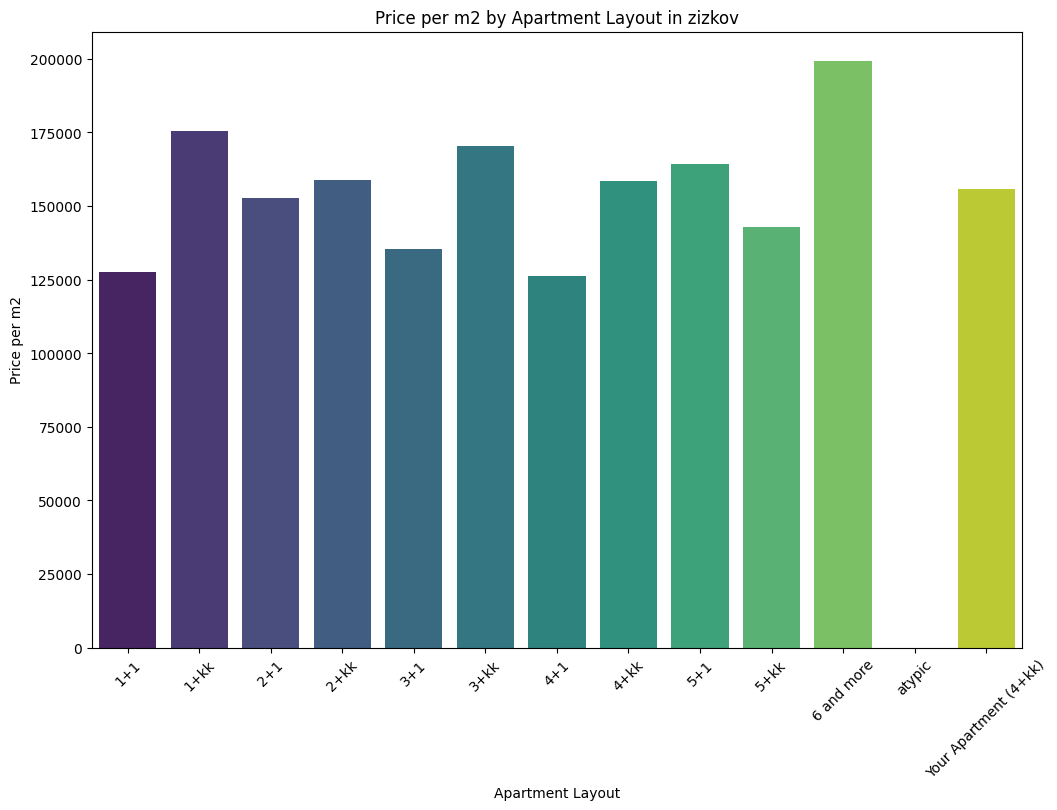

Best parameters found:  {'alpha': np.float64(0.5357894736842106), 'l1_ratio': np.float64(0.9)}


Text(0.5, 1.0, 'What matters in zizkov / Top 10 features')

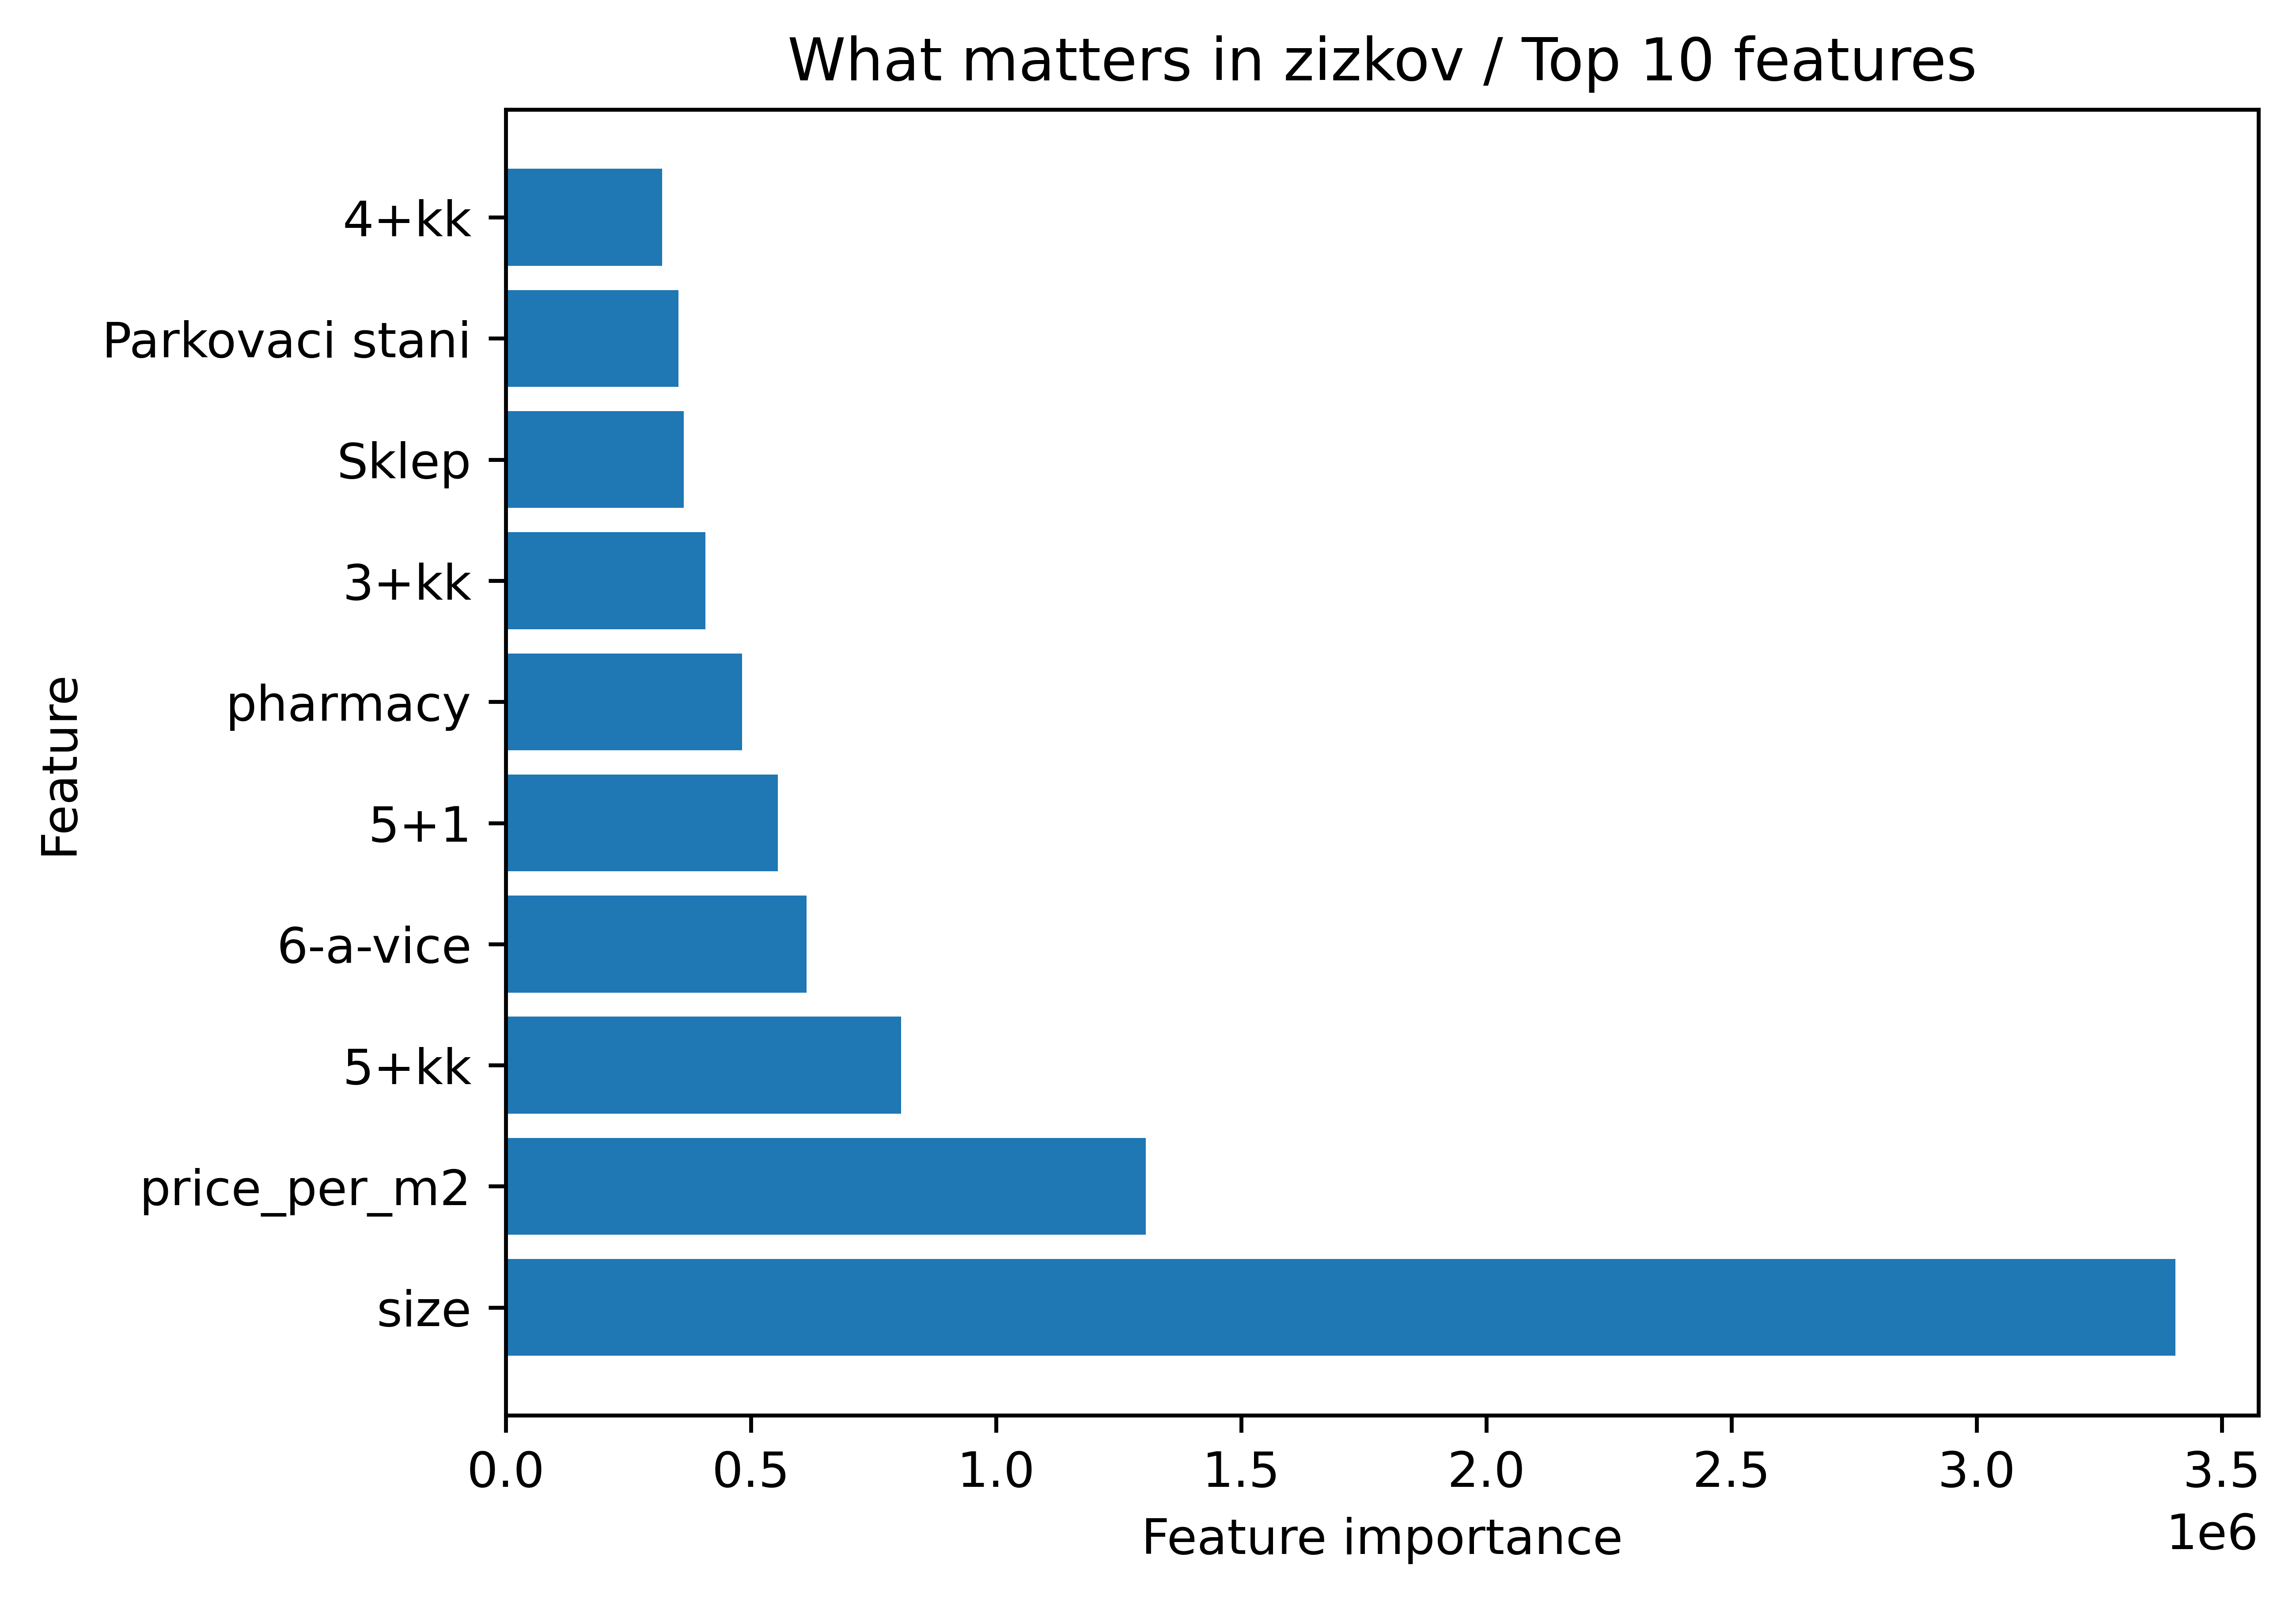

In [59]:
my_apt_layout = ''
for layout in layouts:
    if my_apt[layout] == 1:
        my_apt_layout = layout

target_location = ""
for location in locations:
    if my_apt[location] == 1:
        target_location = location
        # print("Location:", target_location)
        break

apts_in_location = df_imputed[df_imputed[target_location] == 1]


arr_11 = []
arr_1kk = []
arr_21 = []
arr_2kk = []
arr_31 = []
arr_3kk = []
arr_41 = []
arr_4kk = []
arr_51 = []
arr_5kk = []
arr_6plus = []
arr_atypicky = []


for i in range(len(apts_in_location)):
    # print(i)
    apt = apts_in_location.iloc[i]
    if apt['1+1'] == 1:
        arr_11.append(apt)
    elif apt['1+kk'] == 1:
        arr_1kk.append(apt)
    elif apt['2+1'] == 1:
        arr_21.append(apt)
    elif apt['2+kk'] == 1:
        arr_2kk.append(apt)
    elif apt['3+1'] == 1:
        arr_31.append(apt)
    elif apt['3+kk'] == 1:
        arr_3kk.append(apt)
    elif apt['4+1'] == 1:
        arr_41.append(apt)
    elif apt['4+kk'] == 1:
        arr_4kk.append(apt)
    elif apt['5+1'] == 1:
        arr_51.append(apt)
    elif apt['5+kk'] == 1:
        arr_5kk.append(apt)
    elif apt['6-a-vice'] == 1:
        arr_6plus.append(apt)
    elif apt['atypicky'] == 1:
        arr_atypicky.append(apt)

# price_tmp = arr_11[0]['price']
# print(price_tmp)

def getPricePerM2(arr):
    if len(arr) != 0:
        prices_per_m2 = []
        for apt in arr:
            ppm2 = apt['price']/apt['size']
            prices_per_m2.append(ppm2)
        return sum(prices_per_m2) / len(arr)
    else:
        return 0
    
pm2_11 = getPricePerM2(arr_11)
pm2_1kk = getPricePerM2(arr_1kk)
pm2_21 = getPricePerM2(arr_21)
pm2_2kk = getPricePerM2(arr_2kk)
pm2_31 = getPricePerM2(arr_31)
pm2_3kk = getPricePerM2(arr_3kk)
pm2_41 = getPricePerM2(arr_41)
pm2_4kk = getPricePerM2(arr_4kk)
pm2_51 = getPricePerM2(arr_51)
pm2_5kk = getPricePerM2(arr_5kk)
pm2_6plus = getPricePerM2(arr_6plus)
pm2_atypicky = getPricePerM2(arr_atypicky)

# Create a dictionary with the pm2 variables
pm2_values = {
    '1+1': pm2_11,
    '1+kk': pm2_1kk,
    '2+1': pm2_21,
    '2+kk': pm2_2kk,
    '3+1': pm2_31,
    '3+kk': pm2_3kk,
    '4+1': pm2_41,
    '4+kk': pm2_4kk,
    '5+1': pm2_51,
    '5+kk': pm2_5kk,
    '6 and more': pm2_6plus,
    'atypic': pm2_atypicky, 
    'Your Apartment ({})'.format(my_apt_layout): price_prediction/my_apt['size']
}

#convert the dictionary to a DataFrame
pm2_df = pd.DataFrame(list(pm2_values.items()), columns=['Apartment Layout', 'Price per m2'])

#clot the vertical bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Apartment Layout', y='Price per m2', hue='Apartment Layout', data=pm2_df, palette='viridis', dodge=False, legend=False)
plt.title('Price per m2 by Apartment Layout in {}'.format(target_location))
plt.xlabel('Apartment Layout')
plt.ylabel('Price per m2')
plt.xticks(rotation=45)
plt.show()

#top features in your location
#scale the data
scaler = StandardScaler() 

y = apts_in_location['price']
X_scaled = scaler.fit_transform(apts_in_location.drop(columns=['price'])) 

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

elastic_net = ElasticNet(max_iter=100000)
parameters = {
    'alpha': np.linspace(0.01, 10.0, 20),
    'l1_ratio': np.linspace(0.01, 0.9, 20)
}

#set up KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=elastic_net, param_grid=parameters, cv=kf, scoring='r2')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_model2 = grid_search.best_estimator_

# y_pred = best_model2.predict(X_test_scaled)
# # Check if the test set has at least two samples
# if len(y_test) >= 2:
#     r2 = r2_score(y_test, y_pred)
#     print("R² on test data: ", r2)
# else:
#     print("Not enough samples in the test set to calculate R² score.")

coef_abs = (best_model2.coef_)
top_10_feature = np.argsort(coef_abs)[-10:][::-1]
plt.figure(dpi=800)
plt.barh(range(10), best_model2.coef_[top_10_feature], align='center')
plt.yticks(range(10), X.columns[top_10_feature])
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("What matters in {} / Top 10 features".format( apt_location))
